In [30]:
import scipy.io as io
import plotly.offline as py
import plotly.graph_objs as go
import json
import numpy as np

py.init_notebook_mode(connected=True)

In [31]:
mat = io.loadmat('data_Mg_GBperatom_seg_2Al_dump.mat')

length_A = mat['A'].shape[1]

In [32]:
for i in range(30):
    segE = mat['A']['Eseg'][0,i]
    #check whether this is a valid data?
    n1 = segE[:,0] != 0 
    segE = np.squeeze(segE[n1,:])
    atom_ID = segE[:,0].astype(int) - 1

    descriptor = mat['A']['peratom'][0,i][0,0]
    descriptor_temp = np.concatenate([descriptor['pos'],descriptor['pe'],descriptor['cna'],descriptor['centro_fnn'],
                                descriptor['centro_snn'],descriptor['coord'],descriptor['f'],descriptor['stress'],
                                descriptor['voronoi']], axis = 1)
    if i == 0:
        descriptor_all = descriptor_temp[atom_ID]
        segE_all = segE
    else:
        descriptor_temp = descriptor_temp[atom_ID]
        descriptor_all = np.concatenate([descriptor_all, descriptor_temp], axis = 0)
        segE_all = np.concatenate([segE_all, segE])

descriptor_all[:,2] = abs(descriptor_all[:,2]-min(descriptor_all[:,2])-20)
sigma_H = np.sum(descriptor_all[:,11:14], axis = 1)/3
f_mag = np.linalg.norm(descriptor_all[:,8:11], axis = 1, ord = 2)

feature = np.concatenate([descriptor_all, sigma_H[:,np.newaxis], f_mag[:,np.newaxis]], axis = 1)

# Quadratic Regression with Interaction Terms

In [33]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
feature1 = feature[:,3:]
feature1 = feature1/np.max(feature1)
feature2 = np.zeros([feature1.shape[0], 18*18])
for i in range(18):
    feature2[:,i*18:i*18+18] = feature1[:,i][:,np.newaxis]*feature1[:,:]
feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)
np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
#mean = np.mean(X_train, axis = 0)
#std = np.std(X_train, axis = 0)
#X_train = (X_train - mean)/std
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp = (X_temp - mean)/std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

In [108]:
w_pre=np.linalg.pinv(X_train).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

1.2444021240612115

In [109]:
Y_pre_test = X_test.dot(w_pre)
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_test), 2)
R_squared = 1-SS_res/SS_tot

In [111]:
SS_res

0.3042312530584959

In [110]:
R_squared

0.9377665396503908

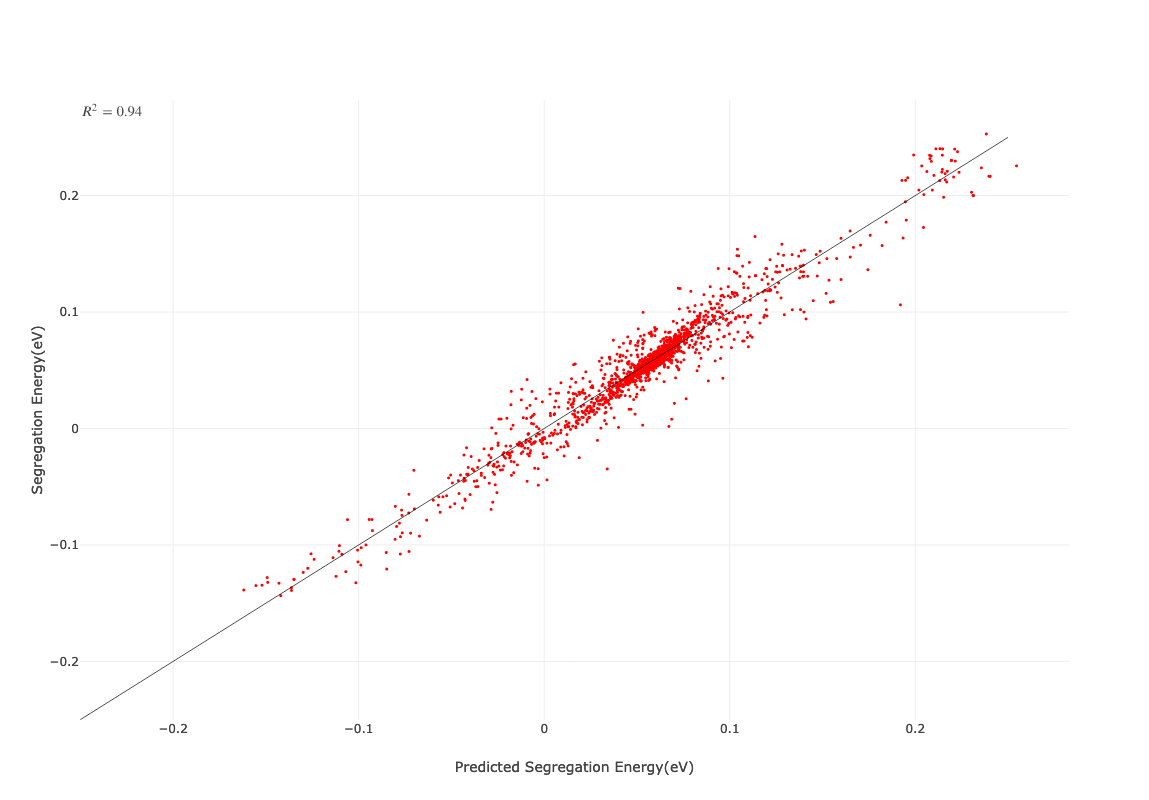

In [39]:
#draw correlation
main = go.Scatter(x = Y_pre_test, 
          y = Y_test, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

## With regularization

In [215]:
lbda = 1.0001e-11
w_pre = np.linalg.inv(X_train.T.dot(X_train) + lbda*np.identity(X_train.shape[1])).dot(X_train.T).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

1.8951958204210904

In [216]:
Y_pre_test = X_test.dot(w_pre)
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_test), 2)
R_squared = 1-SS_res/SS_tot

In [217]:
SS_res

0.4050157591189695

In [218]:
R_squared

0.9171500891749248

# Quadratic regression without interaction terms

In [23]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
feature1 = feature[:,3:]
feature1 = feature1/np.max(feature1)
feature2 = np.power(feature1, 2)
feature_space = np.concatenate([feature1, feature2], axis = 1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature_space], axis = 1)
np.random.seed(10)
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
#mean = np.mean(X_train, axis = 0)
#std = np.std(X_train, axis = 0)
#X_train = (X_train - mean)/std
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp = (X_temp - mean)/std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

In [24]:
w_pre=np.linalg.pinv(X_train).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

1.8610161598799444

In [25]:
Y_pre_test = X_test.dot(w_pre)

Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_test), 2)
R_squared = 1-SS_res/SS_tot

In [26]:
R_squared

0.9133215270738169

In [27]:
SS_res

0.4237318684095187

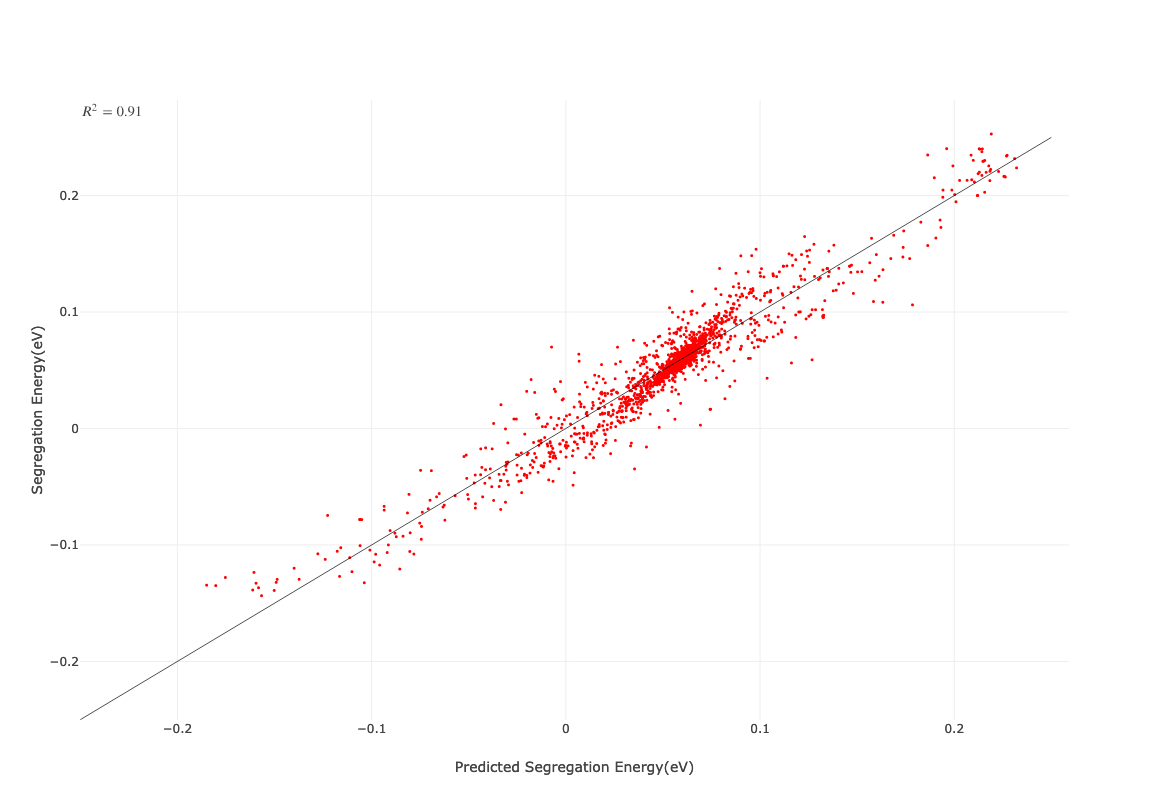

In [28]:
#draw correlation
main = go.Scatter(x = Y_pre_test, 
          y = Y_test, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':0.25,
                            'y0':-0.25,
                            'y1':0.25,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

# 1st Order linear regression

In [33]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
feature1 = feature[:,3:]
feature1 = feature1/np.max(feature1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature1], axis = 1)
w = np.random.randn(38)
λ = 0
#random shuffle
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
#X_train[:,1:] = (X_train[:,1:] - mean[1:])/std[1:]
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp[:,1:] = (X_temp[:,1:] - mean[1:])/std[1:]
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

In [34]:
w_pre=np.linalg.pinv(X_train).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

2.4759727346865126

In [35]:
Y_pre_test = X_test.dot(w_pre)
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_test), 2)
R_squared = 1-SS_res/SS_tot

In [36]:
Y_pre_test - Y_test

array([-0.02723132, -0.00385326,  0.00211641, ...,  0.00589477,
       -0.01129129, -0.00755392])

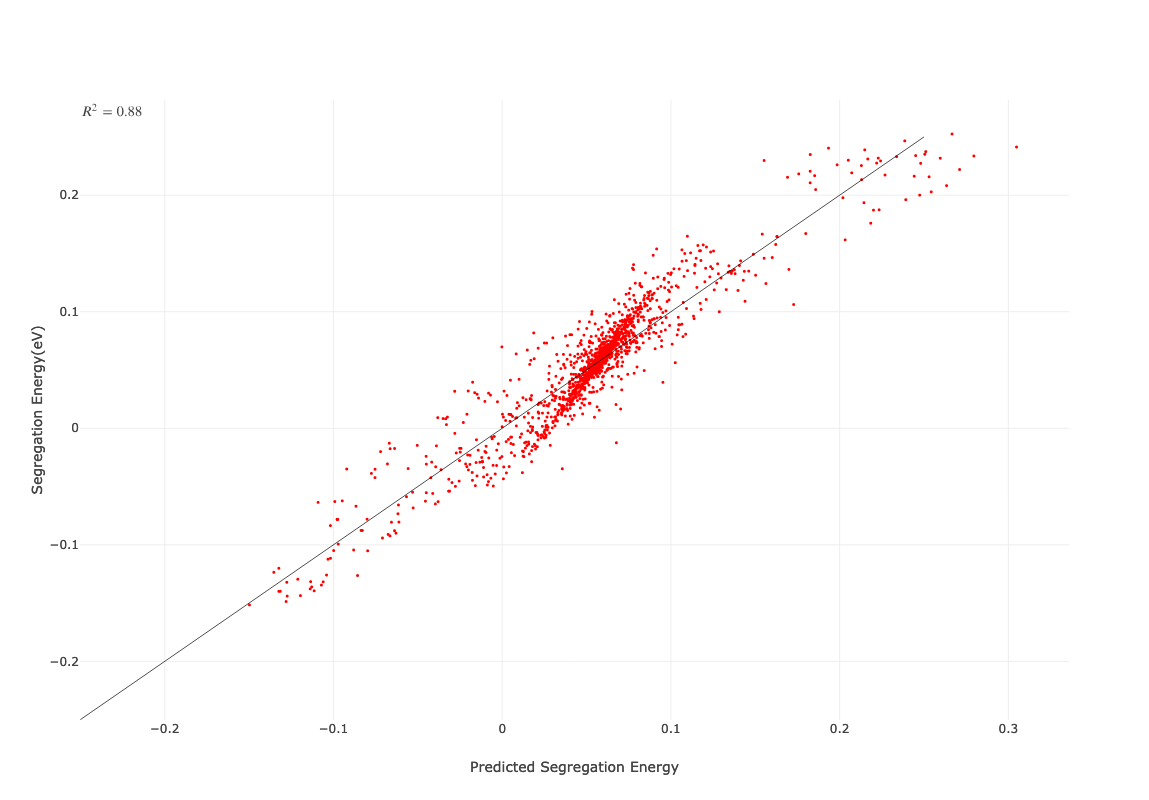

In [37]:
#draw correlation
main = go.Scatter(x = Y_pre_test, 
          y = Y_test, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy", 'zeroline':False},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                    'x0':-0.25,
                    'x1':0.25,
                    'y0':-0.25,
                    'y1':0.25,
                    'line':{'width':0.7}
            }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

# 1st Order linear regression without colinear variables

In [38]:
y_true = segE_all[:,1]
#We should consider the coordinates don't matter.
feature1 = feature[:,3:]
feature1 = feature1[:,:-2]
feature1 = feature1/np.max(feature1)
feature_space = np.concatenate([np.ones((feature1.shape[0],1)), feature1], axis = 1)
w = np.random.randn(38)
λ = 0
#random shuffle
idx0 = np.random.permutation(np.arange(len(feature_space)))
feature_space = feature_space[idx0]
y_true = y_true[idx0]
#divide data into training, crossvalildation and test sets.
X_train = feature_space[0:int(len(feature_space)*.7)]
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
#X_train[:,1:] = (X_train[:,1:] - mean[1:])/std[1:]
X_temp = feature_space[int(len(feature_space)*.7):]
#X_temp[:,1:] = (X_temp[:,1:] - mean[1:])/std[1:]
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_train = y_true[0:int(len(feature_space)*.7)]
Y_temp = y_true[int(len(feature_space)*.7):]
Y_cos = Y_temp[:int(len(X_temp)*.5)]
Y_test = Y_temp[int(len(X_temp)*.5):]

In [39]:
w_pre=np.linalg.pinv(X_train).dot(Y_train)
y1_pre = X_train.dot(w_pre)
np.power(np.linalg.norm(y1_pre-Y_train), 2)

2.497895571801118

In [40]:
Y_pre_test = X_test.dot(w_pre)
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(Y_pre_test-Y_test), 2)
R_squared = 1-SS_res/SS_tot

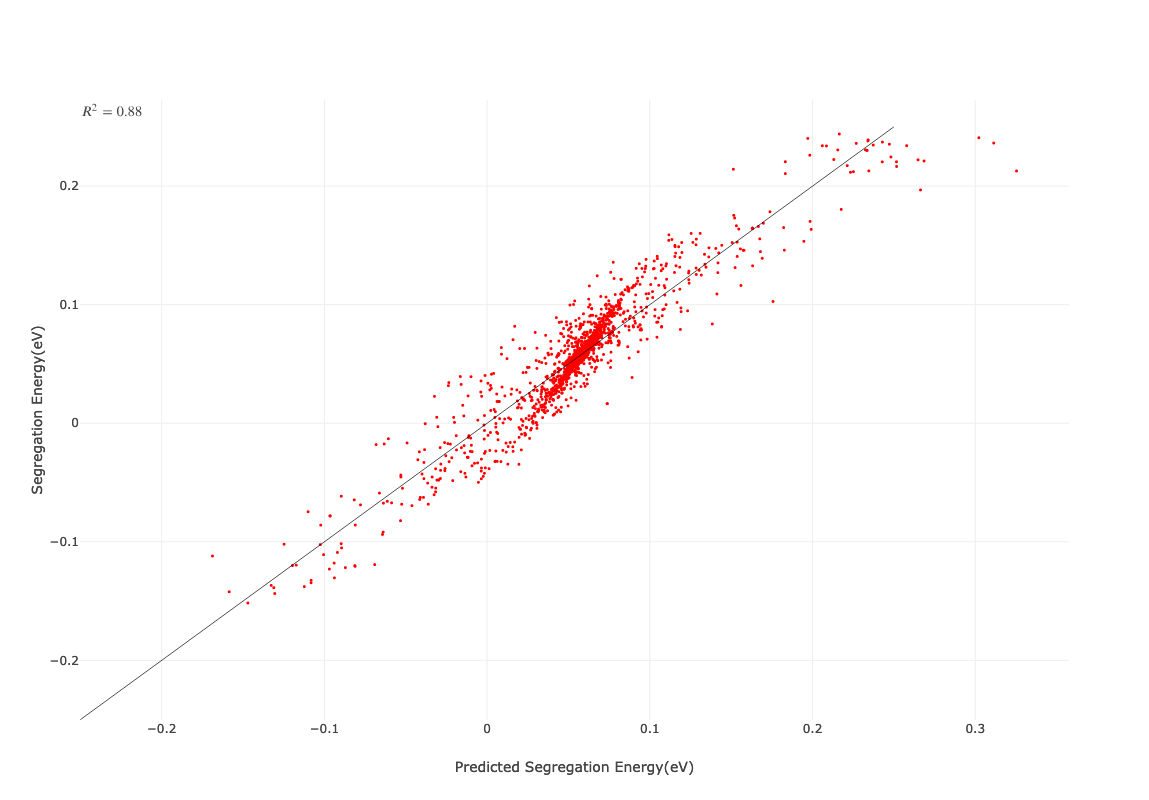

In [41]:
#draw correlation
main = go.Scatter(x = Y_pre_test, 
          y = Y_test, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Segregation Energy(eV)", 'zeroline':False},
           yaxis = {'title':'Segregation Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                    'x0':-0.25,
                    'x1':0.25,
                    'y0':-0.25,
                    'y1':0.25,
                    'line':{'width':0.7}
            }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))